# Microtask 5: 
Same as Microtask-4, but now using pandas.
> Produce a listing of repositories, as a table and as CSV file, with the number of commits authored, issues opened, and pull/merge requests opened, during the last three months, ordered by the total number (commits plus issues plus pull requests) (using pandas).

I am using the same data source file which is used in the [microtask-0](https://github.com/vchrombie/chaoss-microtasks/blob/master/microtask-0/microtask-0.ipynb) i.e, [elasticsearch-py](https://github.com/elastic/elasticsearch-py) project which is located in the `data/` folder of the repository.

In [1]:
# while running this in mybiner notebooks if you are facing 
# dependency errors, you need to uncomment the below lines.

#!pip install prettytable
#!pip install pandas
#!pip install perceval
#!pip install regex
#!pip install matplotlib

# Retrieving the data

You can also retrieve the data source files from the jupyter notebook itself. Just provide your `github_token` (github personal access token) and uncomment the code and run the code in the below cell.

In [2]:
# Please enter your github token here
github_token = "" 
owner = "elastic"
repos = ["elasticsearch-py"]
repos_url = ["https://github.com/" + owner + "/" + repo for repo in repos]
# file to which perceval stores data source
files = [repo+".json" for repo in repos] 
ctypes = ('commit','issue','pull_request')

#for repo, repo_url, file in zip(repos, repos_url, files):
#    print(repo, repo_url, file)
#    !perceval git --json-line $repo_url >> ../$file
#    !perceval github --json-line --sleep-for-rate -t $github_token --category pull_request $owner $repo >> ../data/$file
#    !perceval github --json-line --sleep-for-rate -t $github_token --category issue $owner $repo >> ../data/$file

In [3]:
import json 
import csv  
import regex as re

import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta
from collections import defaultdict  

In [4]:
class Contents_Repository:

    def __init__(self, path):
        """
        """        
        self.repodata = defaultdict(list)
        
        self.df = {
            # commit has the column >> hash, author, date
            'commit':pd.DataFrame(columns=['hash', 'author', 'created_date']),
            # issue has the column >> hash, author, date
            'issue':pd.DataFrame(columns=['hash', 'author', 'created_date']),
            # pr has the column >> hash, author, date
            'pull_request':pd.DataFrame(columns=['hash', 'author', 'created_date'])
        }
        contents = defaultdict(list)

        # to filter out commit, issue, pr details from the data source and store them seperately in dict.
        with open('%s'%path) as datasrc:
            for line in datasrc:
                line = json.loads(line)
                if line['category'] == 'commit':    
                    content = self.summary_commit(line) 
                elif line['category'] == 'issue':    
                    content = self.summary_issue(line)
                elif line['category'] == 'pull_request':    
                    content = self.summary_pr(line) 
                contents[line['category']].append(content)
        for item in contents:
            self.df[item]=self.df[item].append(contents[item],sort=False)
    
    def summary_commit(self, commit):
        repo = commit['origin']
        data = commit['data']
        summary ={
                'repo': repo,
                'hash': data['commit'],
                'author': data['Author'],

                'created_date': datetime.strptime(data['CommitDate'],
                                                          "%a %b %d %H:%M:%S %Y %z")
        }
        return summary

    def summary_issue(self, issue):
        repo = issue['origin']
        data = issue['data']
        summary ={
                'repo': repo,
                'hash': data['id'],
                'author': data['user']['login'],
                'created_date': datetime.strptime(data['created_at'],
                                                  "%Y-%m-%dT%H:%M:%SZ")
        }
        return summary

    def summary_pr(self, pr):
        repo = pr['origin']
        data = pr['data']
        summary ={
                'repo': repo,
                'hash': data['id'],
                'author': data['user']['login'],
                'created_date': datetime.strptime(data['created_at'],
                                                  "%Y-%m-%dT%H:%M:%SZ")
        }  
        return summary
    
    def repo_name(self):
        content_df = self.df
        repourl = "%s"%content_df['commit']['repo'][0]
        reponame = re.split('/', repourl)
        return reponame[-1]

    def get_data_3mon(self):
        repodata = defaultdict(list)
        initial_date = datetime.combine(date.today() - timedelta(3*365/12), 
                                        datetime.min.time())
        # REFERENCE: Stack Overflow https://stackoverflow.com/a/546356/8268998

        repodata['repo'].append(self.repo_name())
        repo_df = self.df
        total = 0
        for ctype in ctypes:
            df = repo_df[ctype]
            df['created_date']= df['created_date'].apply(lambda x:x.replace(tzinfo=None))
            df = df[df['created_date'] >= initial_date]
            repodata[ctype].append(df['hash'].nunique())
            total+=int(df['hash'].nunique())
        repodata['total'].append(total)
        self.repodata = repodata
        return repodata
    
    def show_data_3mon(self):
        print("Repositories Details in the past three months\n")
        rdata = self.repodata
        for item in dict(rdata):
            print (item, dict(rdata)[item])  
        print("\n")

In [5]:
class Display_Repositories:
    def __init__(self):
        """
        """
        self.df = pd.DataFrame(None,columns=['Repository', '# Commits',
                                        '# Issues', '# PRs', '# Total'])
        
    def update_repo(self, repodata):
        li =[]
        for item in dict(repodata):
            li.append(dict(repodata)[item][0])
        self.df = self.df.append({'Repository':li[0], '# Commits':li[1],
                       "# Issues":li[2], "# PRs":li[3], "# Total":li[4]},
                       ignore_index=True)

    def as_csv(self):
        self.df.to_csv('results-%s.csv'%owner,index=None)
        
    def as_table(self):
        print(pd.read_csv('results-%s.csv'%owner))
        
    def data_plot(self):
        self.df.set_index('Repository',drop=True,inplace=True)
        self.df.plot.bar(figsize=(12,8))

        plt.savefig("mt5-bar-%s.png"%owner)

Repositories Details in the past three months

repo ['elasticsearch-py']
commit [4]
issue [19]
pull_request [8]
total [31]


         Repository  # Commits  # Issues  # PRs  # Total
0  elasticsearch-py          4        19      8       31


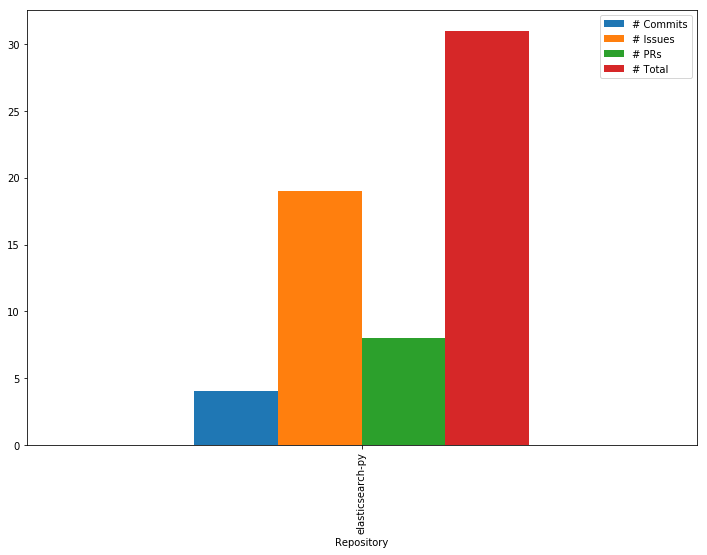

In [6]:
details = Display_Repositories()

for repo in repos:
    repo_obj = Contents_Repository("../data/%s.json"%repo)
    repo_obj.get_data_3mon()
    repo_obj.show_data_3mon()

    details.update_repo(repo_obj.get_data_3mon())

details.as_csv()
details.as_table()
details.data_plot()